# Corn Yield Prediction 

Below is is v0 of Kristin's corn yield prediction model (using 3 measurements of SIF and walk forward validation) and steps I followed:

1. Retrieve Data from Fused UDF-Cornucopia 
2. Create a baseline linear model using the provided formula and treat it as your benchmark.
3. Implement a Random Forest model for yield prediction.
4. Perform a walk-forward validation (train/test splits by year).
5. Reserve a final holdout set to measure out-of-sample performance.


## 1. Baseline Model

Baseline model gathered data from this image (https://www.nass.usda.gov/Charts_and_Maps/Field_Crops/cornyld.php) using data previous to 2015 and removing outliers.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
    
    
#Create baseline model based on USDA Screenshot data from 1995
# Data extracted from the chart
years = np.array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014, 2015, 2016]).reshape(-1, 1)
yields = np.array([113.5, 127.1, 126.7, 134.4, 133.8, 136.9, 138.2, 129.3, 142.2, 160.3, 147.9, 150.7, 153.3, 152.6, 164.4, 146.8, 158.1, 158.1, 171.0, 168.4, 174.6])

# Remove outliers
q1, q3 = np.percentile(yields, [25, 75])
iqr = q3 - q1
mask = (yields >= q1 - 1.5 * iqr) & (yields <= q3 + 1.5 * iqr)
years, yields = years[mask], yields[mask]

# Fit and predict
model = LinearRegression().fit(years, yields)
yield_predictions = model.predict(years)

# Output model and error
print(f"Linear Model: Yield = {model.coef_[0]:.2f} * Year + {model.intercept_:.2f}")
print(f"Mean Squared Error: {mean_squared_error(yields, yield_predictions):.2f}")

#hardcoded baseline model
def baseline_model(year):
    return 2.34 * year - 4547.36




Linear Model: Yield = 2.34 * Year + -4547.36
Mean Squared Error: 36.94


## 2. Retrieve Data from Fused

### Connect to Fuseda and Use Cornucopia UDF. 

We specify the area for the UDF to download data by passing a GeoDataFrame to the bbox parameter.

In [4]:
pip install fused -q

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Run this cell, visit the URL, paste the provided credentials snippet in a new cell
from fused.api import NotebookCredentials
credentials = NotebookCredentials()


Please open this link to authenticate with Fused:

* [https://dev-tjcykxcetrz6bps6.us.auth0.com/authorize?audience=fused-python-api&scope=openid+email+name+offline_access&response_type=code&client_id=CXiwKZQmmyo0rqXZY7pzBgfsF7AL2A9l&redirect_uri=https%3A%2F%2Fwww.fused.io%2Fnotebook_login_redirect&code_challenge_method=S256&code_challenge=_mbZUj3SA_xr0r4VIlJOahCQcDX0Q6-TTXfiSq-rk5A](https://dev-tjcykxcetrz6bps6.us.auth0.com/authorize?audience=fused-python-api&scope=openid+email+name+offline_access&response_type=code&client_id=CXiwKZQmmyo0rqXZY7pzBgfsF7AL2A9l&redirect_uri=https%3A%2F%2Fwww.fused.io%2Fnotebook_login_redirect&code_challenge_method=S256&code_challenge=_mbZUj3SA_xr0r4VIlJOahCQcDX0Q6-TTXfiSq-rk5A)

Once you have logged in, that page will give you a code which you can paste into this notebook to finish logging in.


In [2]:
credentials.finalize(code="_eLzl1HR2p7rPZ3JsKtqkMcPScc6R--WRYpaJwFyOJbGY")

You are now logged in to Fused. :rocket:

In [5]:
import fused
import geopandas as gpd
import shapely
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# bbox = gpd.GeoDataFrame(
#     geometry=[shapely.box(-73.9847, 40.7666, -73.9810, 40.7694)], 
#     crs=4326
# )
# bbox


### Run the Overture UDF

We may run the Fused Overture UDF with [fused.run](https://docs.fused.io/core-concepts/run/). We specify the area to load data with the bbox parameter. The UDF also provides optional parameters to select specific Overture releases, datasets, and columns - giving you flexibility to fetch only the data you need.

#### Buildings

In [ ]:
df = fused.run('fsh_6zh59m43BXZwFulEbTBux4') 
df.head()


,GEOID,year,corn_sif_mean_05a,corn_sif_mean_05b,corn_sif_mean_06a,corn_sif_mean_06b,corn_sif_mean_07a,corn_sif_mean_07b,bushels_per_acre,area_corn_acres,area_county_acres,geometry,m_pct,bushels_area_corn
0,17011,2015,NaN,NaN,0.318445,0.545724,0.633098,0.832933,196.8,277974.096384,5.672941e+13,"POLYGON ((-89.86235 41.584, -89.85775 41.58405...",0.49,5.470530e+07
1,17011,2015,NaN,NaN,0.318445,0.545724,0.633098,0.832933,196.8,277974.096384,5.672941e+13,"POLYGON ((-89.86235 41.584, -89.85775 41.58405...",0.49,5.470530e+07
2,17011,2015,NaN,NaN,0.318445,0.545724,0.633098,0.832933,196.8,272301.155641,5.672941e+13,"POLYGON ((-89.86235 41.584, -89.85775 41.58405...",0.48,5.358887e+07
3,17011,2015,NaN,NaN,0.318445,0.545724,0.633098,0.832933,196.8,266628.214899,5.672941e+13,"POLYGON ((-89.86235 41.584, -89.85775 41.58405...",0.47,5.247243e+07
4,17011,2016,NaN,NaN,0.302459,0.638651,NaN,0.787809,203.9,289319.977869,5.672941e+13,"POLYGON ((-89.86235 41.584, -89.85775 41.58405...",0.51,5.899234e+07


In [ ]:
null_counts = df.isnull().sum()
print(null_counts)


GEOID                  0
year                   0
corn_sif_mean_05a    250
corn_sif_mean_05b    242
corn_sif_mean_06a    118
corn_sif_mean_06b     41
corn_sif_mean_07a     31
corn_sif_mean_07b      7
bushels_per_acre       0
area_corn_acres        0
area_county_acres      0
geometry               0
m_pct                  0
bushels_area_corn      0
dtype: int64
              year  corn_sif_mean_05a  corn_sif_mean_05b  corn_sif_mean_06a  \
count   985.000000         735.000000         743.000000         867.000000   
mean   2017.710660           0.088881           0.113977           0.217107   
std       2.094451           0.069518           0.034496           0.046519   
min    2015.000000           0.020314           0.038557           0.127666   
25%    2016.000000           0.055085           0.088802           0.191036   
50%    2019.000000           0.073258           0.109015           0.217842   
75%    2020.000000           0.092232           0.134641           0.238010   
max  

In [15]:
# print(df.describe())

              year  corn_sif_mean_05a  corn_sif_mean_05b  corn_sif_mean_06a  \
count   985.000000         735.000000         743.000000         867.000000   
mean   2017.710660           0.088881           0.113977           0.217107   
std       2.094451           0.069518           0.034496           0.046519   
min    2015.000000           0.020314           0.038557           0.127666   
25%    2016.000000           0.055085           0.088802           0.191036   
50%    2019.000000           0.073258           0.109015           0.217842   
75%    2020.000000           0.092232           0.134641           0.238010   
max    2020.000000           0.511090           0.223987           0.410659   

       corn_sif_mean_06b  corn_sif_mean_07a  corn_sif_mean_07b  \
count         944.000000         954.000000         978.000000   
mean            0.414805           0.636260           0.749627   
std             0.109445           0.089481           0.071664   
min             0.155770

### Simplified Approach

Train on 2015–2017

Validation on 2018–2019 (walk-forward)

Holdout on 2020

In [7]:
df = df.sort_values('year').reset_index(drop=True)
holdout_year = 2020

df_holdout = df[df['year'] == holdout_year].copy()
df_pre_holdout = df[df['year'] < holdout_year].copy()

features = ['corn_sif_mean_05b', 'corn_sif_mean_06a', 'corn_sif_mean_06b',
            'area_corn_acres', 'area_county_acres', 'm_pct']

all_years = sorted(df_pre_holdout['year'].unique())

all_predictions = []
all_actuals = []

for test_year in all_years[1:]:  # e.g., 2016 to 2019
    train_data = df_pre_holdout[df_pre_holdout['year'] < test_year]
    test_data = df_pre_holdout[df_pre_holdout['year'] == test_year]
    
    X_train = train_data[features]
    y_train = train_data['bushels_per_acre']
    X_test = test_data[features]
    y_test = test_data['bushels_per_acre']
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    all_predictions.extend(y_pred)
    all_actuals.extend(y_test.values)

overall_mse = mean_squared_error(all_actuals, all_predictions)
overall_rmse = np.sqrt(overall_mse)

print(f"Walk-forward MSE: {overall_mse:.2f}")
print(f"Walk-forward RMSE: {overall_rmse:.2f}")

# -----------------------------
# 5) Compare to Baseline
# -----------------------------
df_pre_holdout['baseline_pred'] = df_pre_holdout['year'].apply(baseline_model)
baseline_mse = mean_squared_error(df_pre_holdout['bushels_per_acre'],
                                  df_pre_holdout['baseline_pred'])
baseline_rmse = np.sqrt(baseline_mse)

print(f"Baseline MSE: {baseline_mse:.2f}")
print(f"Baseline RMSE: {baseline_rmse:.2f}")

# -----------------------------
# 6) Final Holdout Evaluation
# -----------------------------
X_train = df_pre_holdout[features]
y_train = df_pre_holdout['bushels_per_acre']

X_holdout = df_holdout[features]
y_holdout = df_holdout['bushels_per_acre']

rf_final = RandomForestRegressor(n_estimators=100, random_state=42)
rf_final.fit(X_train, y_train)

y_holdout_pred = rf_final.predict(X_holdout)

holdout_mse = mean_squared_error(y_holdout, y_holdout_pred)
holdout_rmse = np.sqrt(holdout_mse)

print(f"Holdout MSE (year={holdout_year}): {holdout_mse:.2f}")
print(f"Holdout RMSE (year={holdout_year}): {holdout_rmse:.2f}")


Walk-forward MSE: 2502.83
Walk-forward RMSE: 50.03
Baseline MSE: 1098.50
Baseline RMSE: 33.14
Holdout MSE (year=2020): 315.29
Holdout RMSE (year=2020): 17.76


### Year by Year Walk Forward


In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# -----------------------------
# 1) Sort your data by year
# -----------------------------
df = df.sort_values('year').reset_index(drop=True)

# We assume these are the predictive features.
features = ['corn_sif_mean_05b', 'corn_sif_mean_06a', 'corn_sif_mean_06b',
            'area_corn_acres', 'area_county_acres', 'm_pct']

target = 'bushels_per_acre'

# -----------------------------
# 2) List unique years in ascending order
# -----------------------------
all_years = sorted(df['year'].unique())

# -----------------------------
# 3) Prepare data structure to save results
# -----------------------------
yearly_results = []  # Will hold per-year results

# -----------------------------
# 4) Walk-forward loop, year-by-year
# -----------------------------
# Example: If all_years = [2015, 2016, 2017, 2018, 2019, 2020],
# we start testing from the second year in the list (e.g., 2016),
# because we need at least one year to train on (2015).
for test_year in all_years[1:]:
    # 4.1) Training data = all years < test_year
    train_data = df[df['year'] < test_year]
    # 4.2) Testing data = exactly test_year
    test_data = df[df['year'] == test_year]
    
    # Skip if we don't have training or testing rows
    if train_data.empty or test_data.empty:
        continue
    
    # 4.3) Define X and y
    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]
    
    # 4.4) Fit the model (Random Forest example)
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # 4.5) Predict on the test set
    y_pred = rf.predict(X_test)
    
    # 4.6) Calculate metrics for this test_year
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # 4.7) Store the results in a list
    yearly_results.append({
        'test_year': test_year,
        'mse': mse,
        'rmse': rmse,
        'n_samples': len(test_data)
    })

# -----------------------------
# 5) Summarize results
# -----------------------------
results_df = pd.DataFrame(yearly_results)
print("Year-by-Year Results:")
print(results_df)

print("\nAverage MSE: {:.2f}".format(results_df['mse'].mean()))
print("Average RMSE: {:.2f}".format(results_df['rmse'].mean()))


Year-by-Year Results:
   test_year          mse       rmse  n_samples
0       2016   615.408696  24.807432        212
1       2019  4195.874368  64.775569        237
2       2020   311.550442  17.650792        302

Average MSE: 1707.61
Average RMSE: 35.74


41


<Axes: >

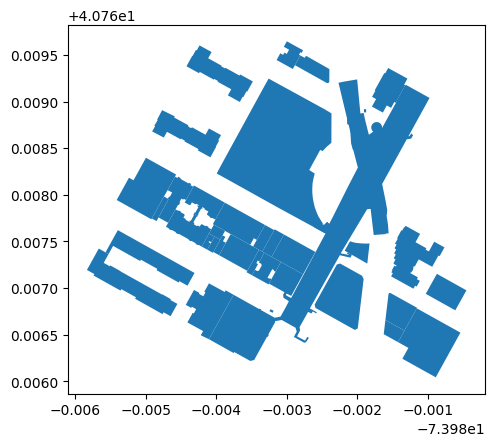

In [2]:
gdf = fused.run('UDF_Overture_Maps_Example', bbox=bbox, overture_type='building') 
print(len(gdf))
gdf.plot()

#### Places

In [3]:
gdf = fused.run('UDF_Overture_Maps_Example', bbox=bbox, overture_type='place') 
gdf.head(2)

,id,geometry,bbox,version,sources,names,categories,confidence,websites,socials,emails,phones,brand,addresses
306,08f2a1008b24a79e034682c6c103240b,POINT (-73.9847 40.76736),"{'xmax': -73.98469543457031, 'xmin': -73.98470...",0,"[{'confidence': None, 'dataset': 'meta', 'prop...","{'common': None, 'primary': 'Sfilatino Italian...","{'alternate': ['italian_restaurant', 'restaura...",0.990185,[http://www.sfilatinonyc.com/],[https://www.facebook.com/101812816624423],None,[+16464769856],None,"[{'country': 'US', 'freeform': '342 W 57th St'..."
553,08f2a100d65160860308e7269804dcb7,POINT (-73.98404 40.76661),"{'xmax': -73.9840316772461, 'xmin': -73.984039...",0,"[{'confidence': None, 'dataset': 'meta', 'prop...","{'common': None, 'primary': 'Alamo Rent A Car'...","{'alternate': ['travel'], 'primary': 'car_rent...",0.989360,[https://www.alamo.com/en/car-rental-locations...,[https://www.facebook.com/404470783085116],None,[+16466924999],"{'names': {'common': None, 'primary': 'Alamo R...","[{'country': 'US', 'freeform': '313 W 56th St'..."


## 3. Create custom UDFs

### 3.1 Basic UDF to load Overture Buildings

In [4]:
# Define the UDF
@fused.udf
def udf(bbox: fused.types.TileGDF):

    # Load Overture Buildings
    gdf_overture = fused.utils.Overture_Maps_Example.get_overture(bbox=bbox, overture_type='building')

    return gdf_overture

# Run the UDF
gdf = fused.run(udf, bbox=bbox)

print(len(gdf))

41


### 3.2 UDF to get GERS for an address

In [5]:
@fused.udf
def udf_gers(place_name, h3_size=15):
    from geopy.geocoders import Nominatim
    import h3
    import pandas as pd
    from shapely.geometry import Polygon
    import geopandas as gpd

    # 1. Geocode 
    location = Nominatim(user_agent="geoapi_example").geocode(place_name)
    h3_index = h3.latlng_to_cell(location.latitude, location.longitude, h3_size)
    bounds = Polygon([coord[::-1] for coord in h3.cell_to_boundary(h3_index)])
    gdf = gpd.GeoDataFrame({'h3_index': [h3_index], 'geometry': [bounds]})

    print(f"Address: {location.address}")
    print(f"Latitude: {location.latitude}")
    print(f"Longitude: {location.longitude}")
    print(f"H3 Index: {h3_index}")

    # 2. Load Overture Buildings
    # gdf_overture = fused.run("UDF_Overture_Maps_Example", bbox=gdf, overture_type='building')
    gdf_overture = fused.utils.Overture_Maps_Example.get_overture(bbox=gdf, overture_type='building')

    # 3. Structure output
    return pd.DataFrame({'gers': [gdf_overture.iloc[0].id], 'hex': [h3_index], 'address': [location.address], 'lat': [location.latitude], 'lon': [location.longitude]})

gdf = fused.run(udf_gers, place_name="1600 Amphitheatre Parkway, Mountain View, CA")
gdf

Address: Google Building 41, 1600, Amphitheatre Parkway, Mountain View, Santa Clara County, California, 94043, United States
Latitude: 37.42248575
Longitude: -122.08558456613565
H3 Index: 8f283475085d4c0


,gers,hex,address,lat,lon
0,08b283475085dfff0200fad48d99216d,8f283475085d4c0,"Google Building 41, 1600, Amphitheatre Parkway...",37.422486,-122.085585


### 3.3 UDF to get Buildings for an H3

This function accepts an H3 index as input, queries the corresponding Parquet files for all places within the H3 boundary, and rolls up the queried buildings/places into a summarized listing.


#### Run once

In [4]:
import fused

In [5]:
@fused.udf
def udf_h3_to_overture(h3_index, overture_type='place'):
    import h3
    from shapely.geometry import Polygon
    import geopandas as gpd
    import fused

    # 1. Polygon from H3
    bounds = Polygon([coord[::-1] for coord in h3.cell_to_boundary(h3_index)])
    gdf = gpd.GeoDataFrame({'h3_index': [h3_index], 'geometry': [bounds]})

    # 2. Load Overture Buildings
    gdf_overture = fused.utils.Overture_Maps_Example.get_overture(bbox=gdf, overture_type='building')

    return gdf_overture


gdf = fused.run(udf_h3_to_overture, h3_index='8a283082b147fff')
print(len(gdf))
gdf.head(2)

18


,id,geometry,bbox,version,sources,subtype,class,names,level,has_parts,...,min_height,min_floor,facade_color,facade_material,roof_material,roof_shape,roof_direction,roof_orientation,roof_color,roof_height
10793,08b283082b145fff0200824a1bf93654,"POLYGON ((-122.42329 37.79379, -122.42331 37.7...","{'xmax': -122.4232406616211, 'xmin': -122.4236...",0,"[{'confidence': None, 'dataset': 'OpenStreetMa...",None,None,None,NaN,False,...,NaN,NaN,None,None,None,None,NaN,None,None,NaN
10794,08b283082b16afff02005e983b3c26c2,"POLYGON ((-122.42376 37.79395, -122.42377 37.7...","{'xmax': -122.42375183105469, 'xmin': -122.424...",0,"[{'confidence': None, 'dataset': 'OpenStreetMa...",None,None,None,NaN,False,...,NaN,NaN,None,None,None,None,NaN,None,None,NaN


#### Run in parallel

In [6]:
import pandas as pd

@fused.cache
def run_udfs(h3_index):
    gdf = fused.run(udf_h3_to_overture, h3_index=h3_index, overture_type='building')
    gdf['h3_index'] = h3_index
    gdf.insert(0, 'h3_index', gdf.pop('h3_index'))
    return gdf


h3s = [
    '8f283475085d4c0',
    '8f283080d9a1381',
    '8c283080d9a13ff',
    '8c283082b144bff',
    '8a283082b147fff'
]

gdfs = fused.utils.common.run_pool(run_udfs, h3s, max_workers=5)

gdf = pd.concat(gdfs)
gdf.head(10)[['h3_index', 'id', 'names']]

,h3_index,id,names
3722,8f283475085d4c0,08b283475085dfff0200fad48d99216d,"{'common': None, 'primary': 'Google Building 4..."
15266,8f283080d9a1381,08b283080d9a1fff020011bbbd0b8834,"{'common': None, 'primary': 'Dolphin Club', 'r..."
15266,8c283080d9a13ff,08b283080d9a1fff020011bbbd0b8834,"{'common': None, 'primary': 'Dolphin Club', 'r..."
10836,8c283082b144bff,08b283082b163fff020093b388d5e982,None
10793,8a283082b147fff,08b283082b145fff0200824a1bf93654,None
10794,8a283082b147fff,08b283082b16afff02005e983b3c26c2,None
10795,8a283082b147fff,08b283082b141fff0200ddb6a9aa3dce,None
10836,8a283082b147fff,08b283082b163fff020093b388d5e982,None
10837,8a283082b147fff,08b283082b145fff020053ec10837685,None
10839,8a283082b147fff,08b283082b171fff02005cb7f93e278b,"{'common': [['en', 'House of Prime Rib']], 'pr..."


### 3.5 Embeddings


Cluster Places data in an AOI by H3 then create embeddings to eventually use for search. 

Rolling up by H3 can make queries more efficient, enable privacy preserving features, and add more signal to a GERS. A user could pass an H3 and get info.

This UDF queries Overture Places by H3 tile, extracts a set of categories, counts POIs.

As a subsequent step, one could inspect spatial pairs, inspect each embedding to see top categories and label it with an LLM.


#### Run once

In [7]:
@fused.udf
def udf_h3_embedding(h3_index):
    import h3
    from shapely.geometry import Polygon
    import geopandas as gpd
    from sklearn.feature_extraction.text import TfidfVectorizer
    import pandas as pd

    # 1. Polygon from H3
    bounds = Polygon([coord[::-1] for coord in h3.cell_to_boundary(h3_index)])
    bbox = gpd.GeoDataFrame({'h3_index': [h3_index], 'geometry': [bounds]})

    # 2. Load Overture Buildings
    gdf = fused.utils.Overture_Maps_Example.get_overture(bbox=bbox, overture_type='place')

    # 3. Normalize the 'categories' column into individual columns
    categories_df = pd.json_normalize(gdf['categories']).reset_index(drop=True)
    categories_df.rename(columns={"primary": "categories_primary"}, inplace=True)
    names_df = pd.json_normalize(gdf['names']).reset_index(drop=True)
    names_df.rename(columns={"primary": "names_primary"}, inplace=True)

    # 4. Concatenate the new columns back into the original GeoDataFrame
    gdf2 = pd.concat([gdf.drop(columns=['categories', 'names']).reset_index(), categories_df, names_df], axis=1)
    gdf2['h3_index'] = gdf2.geometry.apply(lambda p: h3.latlng_to_cell(p.y, p.x, 10))
    gdf2[['h3_index', 'brand', 'alternate', 'common', 'categories_primary', 'names_primary']]

    # 5. Group by H3, create categories primary set
    gdf3 = gdf2.dissolve(by='h3_index', as_index=False, aggfunc={'categories_primary': lambda x: list([y for y in set(x) if pd.notna(y)])})

    # 6. Convert TF-IDF matrix to a list of embeddings (dense vectors)
    global_categories = ['temp_agency','advertising_agency','property_management','spas','physical_therapy','arts_and_crafts','massage','health_and_medical', 'chiropractor','dentist','pharmacy','counseling_and_mental_health','online_shop','business_management_services','laboratory_testing','family_practice','hospital','lawyer','bus_station','tattoo_and_piercing','event_planning','bankruptcy_law','skin_care','auto_electrical_repair','nutritionist','social_service_organizations','osteopathic_physician','gym','neurologist','acupuncture','american_restaurant','specialty_school','automotive_repair','boxing_class','doctor','speech_therapist']
    vectorizer = TfidfVectorizer(vocabulary=global_categories) # Align with the same feature space (for consistent vocabulary)
    gdf3['embedding'] = gdf3['categories_primary'].apply(lambda x: vectorizer.fit_transform([' '.join(x)]).toarray()[0].tolist())


    return gdf3


gdf = fused.run(udf_h3_embedding, h3_index='8a283082b147fff')
print(len(gdf))
gdf.head(2)

1


,h3_index,geometry,categories_primary,embedding
0,8a283082b147fff,"MULTIPOINT (-122.42354 37.79408, -122.4235 37....","[event_planning, family_practice, advertising_...","[0.16666666666666666, 0.16666666666666666, 0.1..."


#### Run for multiple H3

In [10]:
import h3
import geopandas as gpd
aoi = gpd.GeoDataFrame.from_features({"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"coordinates":[[[-122.41004781019907,37.79728323117469],[-122.41004781019907,37.78691962472689],[-122.39762810546189,37.78691962472689],[-122.39762810546189,37.79728323117469],[-122.41004781019907,37.79728323117469]]],"type":"Polygon"}}]})
h3s = h3.polygon_to_cells(h3.geo_to_h3shape(aoi.geometry.iloc[0]), 10)

@fused.cache
def run_udfs(h3_index):
    gdf = fused.run(udf_h3_embedding, h3_index=h3_index)
    gdf['h3_index'] = h3_index
    gdf.insert(0, 'h3_index', gdf.pop('h3_index'))
    return gdf

gdfs = fused.utils.common.run_pool(run_udfs, h3s, max_workers=5)

gdf = pd.concat(gdfs)
gdf.head(5)


,h3_index,geometry,categories_primary,embedding
0,8a283082a2dffff,"MULTIPOINT (-122.40236 37.79673, -122.40232 37...","[shoe_store, bridal_shop, public_and_governmen...","[0.0, 0.5773502691896258, 0.0, 0.0, 0.0, 0.577..."
0,8a283082bca7fff,"MULTIPOINT (-122.4098 37.7903, -122.40978 37.7...","[atms, parking, neurologist, graphic_designer,...","[0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
0,8a283082a28ffff,"MULTIPOINT (-122.40011 37.79469, -122.40008 37...","[pizza_restaurant, investing, real_estate, tob...","[0.0, 0.0, 0.4082482904638631, 0.0, 0.0, 0.0, ..."
0,8a283082a307fff,"MULTIPOINT (-122.40243 37.78936, -122.40242 37...","[psychotherapist, installment_loans, men's_clo...","[0.0, 0.2581988897471611, 0.0, 0.2581988897471..."
0,8a283082a267fff,"MULTIPOINT (-122.40656 37.79252, -122.40648 37...","[business_management_services, marketing_agenc...","[0.0, 0.35355339059327373, 0.35355339059327373..."


#### Cluster output

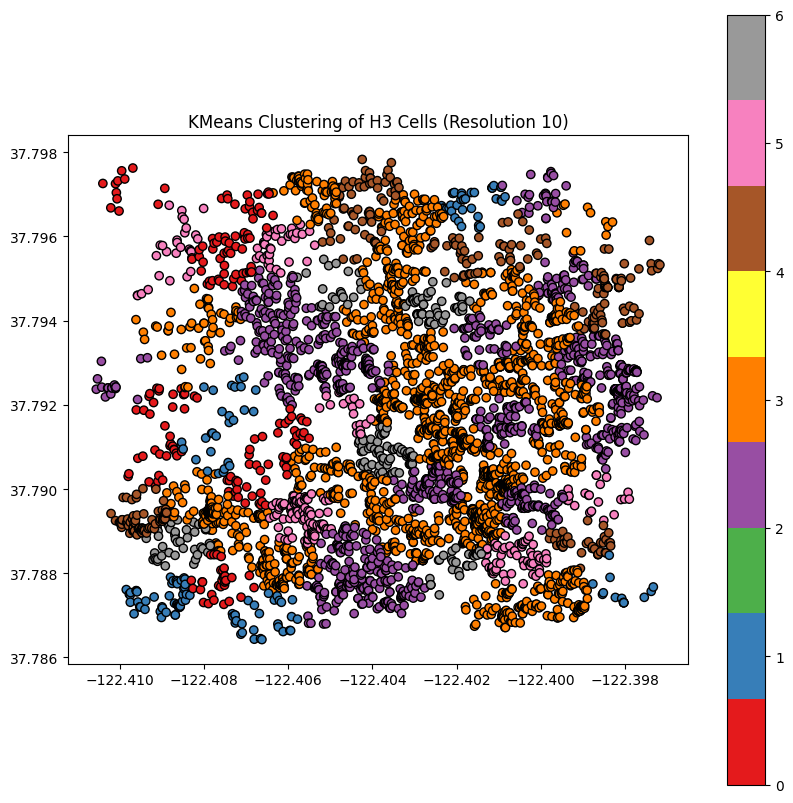

H3 Clustering Results:
           h3_index  cluster
0   8a283082a2dffff        1
0   8a283082bca7fff        0
0   8a283082a28ffff        2
0   8a283082a307fff        3
0   8a283082a267fff        2
..              ...      ...
0   8a283082bdb7fff        0
0   8a283082a047fff        1
0   8a283082a06ffff        3
0   8a283082aadffff        2
0   8a283082b527fff        3

[79 rows x 2 columns]


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

embeddings = gdf.embedding.tolist()
similarity_matrix = cosine_similarity(embeddings)


# Step 5: Perform clustering using KMeans
num_clusters = 7  # Adjust the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
gdf['cluster'] = kmeans.fit_predict(embeddings)

# Step 6: Visualize the clustered H3 cells
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(ax=ax, edgecolor='black', column='cluster', cmap='Set1', legend=True)

plt.title(f"KMeans Clustering of H3 Cells (Resolution 10)")
plt.show()

# Output the clusters
print("H3 Clustering Results:")
print(gdf[['h3_index', 'cluster']])